In [3]:
#-----------------------------------#
# Target: for evaluating the forecasted data versus true data
# DATA: predicted appended IMFS and smapi within Huai river basin 
# author: X.W.
# 6-28-2022
#-----------------------------------#
import xarray as xr
import pandas as pd
#import geopandas as gpd
import numpy as np
import os
import glob
#from tqdm.notebook import tqdm
import pylab as plt

In [4]:
# 读取文件名的函数
def read_file(path, file_type):  # path 是指需要提取的文件夹所在路径;file_type是指文件的拓展名;txt格式的文件则输入‘.txt’
    filenames = os.listdir(path)
    filenames1 = []
    for filename in filenames:
        if os.path.splitext(filename)[1] == file_type:
            filenames1.append(filename)
    return filenames1

In [5]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import os
def plot_hrb(data,idx_matrix, label_title):
    fig = plt.figure(figsize=(10, 4))
    plt.rcParams['axes.linewidth'] = 2.5
    ax = plt.subplot(projection=ccrs.PlateCarree())
    # plt.title('From '+str(df_predict.loc['TARGET'].index[0])[0:10]+' to '+
    #           str(df_predict.loc['TARGET'].index[-1])[0:10], fontsize=16, weight='bold')
    cmap = plt.get_cmap('jet')
    dtplot = plt.pcolormesh(data.lon.values,data.lat.values,idx_matrix,cmap=cmap,vmin = 0,vmax =1)
    #plt.plot(x,y,c='k')
    cbar = plt.colorbar(dtplot, label=label_title)
    cbar.ax.axes.tick_params(length=0)
    cbar.ax.tick_params(labelsize=14)
    ax.set_aspect('equal')
    gl=ax.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = mticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    plt.axis([111.8,121.5,30.8,36.4])
    plt.tight_layout()
    #plt.save('E:\\jupyter_output_figs\\val_metrics\\'+label_title+'.png')

In [6]:
dir_path = r'E:\Data_inputs\fost_appended_outputs_v1'
os.chdir(dir_path)
curr_path = os.getcwd()  # 获取当前路径
fct_files = read_file(curr_path, '.nc')  # 利用上述函数获取当前文件夹内的.nc文件名
fct_files

['Appended_predicted_imfs_0_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_1_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_2_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_3_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_4_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_5_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_6_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_7_from_Mar2019_to_Dec2020.nc',
 'smapi_aggregated_from_IMFs_from_Mar2019_to_Dec2020.nc']

In [7]:
smi_imf = xr.open_dataset(fct_files[-1])
smi_self = xr.open_dataset(fct_files[-2])
dt_imf = smi_imf['smapi'].values[:-4,:,:]
dt_self = smi_self['imf'].values[:-4,:,:]

In [8]:
os.chdir(r'E:\Data_inputs\masked_data_HRB')  # 更改工作路径
curr_path = os.getcwd()  # 获取当前路径
files = read_file(curr_path, '.nc')  # 利用上述函数获取当前文件夹内的.nc文件名
# 最后一个文件是smapi，注意区分
smi_true = xr.open_dataset(files[-1])
#dt = data['imf'].values
#df = pd.DataFrame(dt.reshape((dt.shape[0],-1)))
# id_nan = df[df.columns[df.isnull().any()]].columns
dt_true = smi_true['smapi'].values
dt_true = dt_true[2043:-1]

In [9]:
p = np.random.randn(24)
t = np.random.randn(24)
sse = np.sum((p-t)**2)
lead_time = 1
sse_naive = np.sum((t[1:]-t[:-1])**2)
pers = 1-sse/sse_naive
pers

0.2690896450849528

In [10]:
# basic metrics:
# prediction skill: spatial cosine similarity
# R, RMSE, RBIAS
from sklearn import metrics
from scipy import stats
from scipy.spatial import distance
def classical_metrics(p,t):
    cs = 1-distance.cosine(p,t)
    cc = stats.pearsonr(t,p)[0]
    rmse = metrics.mean_squared_error(t,p,squared=False)
    rbias = np.nansum(p-t)/np.nansum(t)
    return cs, cc, rmse, rbias

In [13]:
from sklearn import metrics
from scipy import stats
from scipy.spatial import distance
def stats_idx(p,t):
    indices = np.logical_not(np.logical_or(np.isnan(p), np.isnan(t)))
    p = p[indices]
    t = t[indices]
    r = stats.pearsonr(t,p)[0]
    rmse = metrics.mean_squared_error(t,p,squared=False)
    r2 = metrics.r2_score(t,p)
    nse = 1-(np.sum((p-t)**2)/np.sum((t-np.mean(t))**2))
    return r, rmse, r2, nse

In [14]:
from tqdm.notebook import tqdm
basic_idx1 = np.zeros([4,dt_true.shape[1],dt_true.shape[2]])*np.nan
basic_idx2 = basic_idx1.copy()
from scipy.spatial import distance
for ii in tqdm(range(dt_true.shape[1])):
    for jj in range(dt_true.shape[2]):
        ts_fct1 = dt_imf[:,ii,jj]
        ts_fct2 = dt_self[:,ii,jj]
        ts_val = dt_true[:,ii,jj]
        if np.isnan(ts_val).all() == True:
            basic_idx1[:,ii,jj] = np.nan
            basic_idx2[:,ii,jj] = np.nan
        else:  
            med_idx1 = stats_idx(ts_fct1,ts_val)
            med_idx2 = stats_idx(ts_fct2,ts_val)
            for kk in range(4):
                basic_idx1[kk,ii,jj] = med_idx1[kk]
                basic_idx2[kk,ii,jj] = med_idx2[kk]
        #print(ii,jj,cos_idx[ii,jj])

  0%|          | 0/64 [00:00<?, ?it/s]

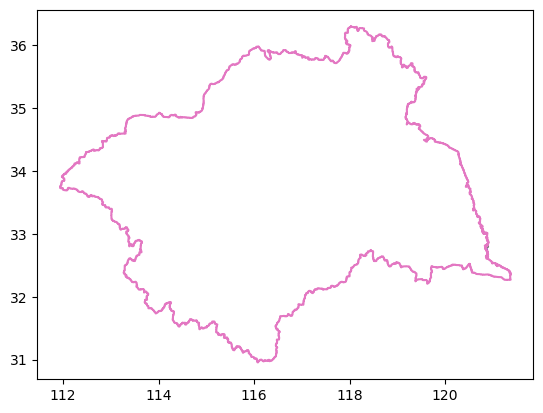

In [12]:
import shapefile
#sf = shapefile.Reader(r'C:\Users\Xiaoyi Wang\Documents\WeChat Files\wxid_brbhsoiwov5q21\FileStorage\MsgAttach\e1af2439ac51d5b33a9a4b5a39835f37\File\2022-06\huaibeiPlain.zip')
sf = shapefile.Reader(r'E:\shp\Huai_Edge\HRB_edge_polygon.shp')
sf.shapeType == shapefile.POLYGON
plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

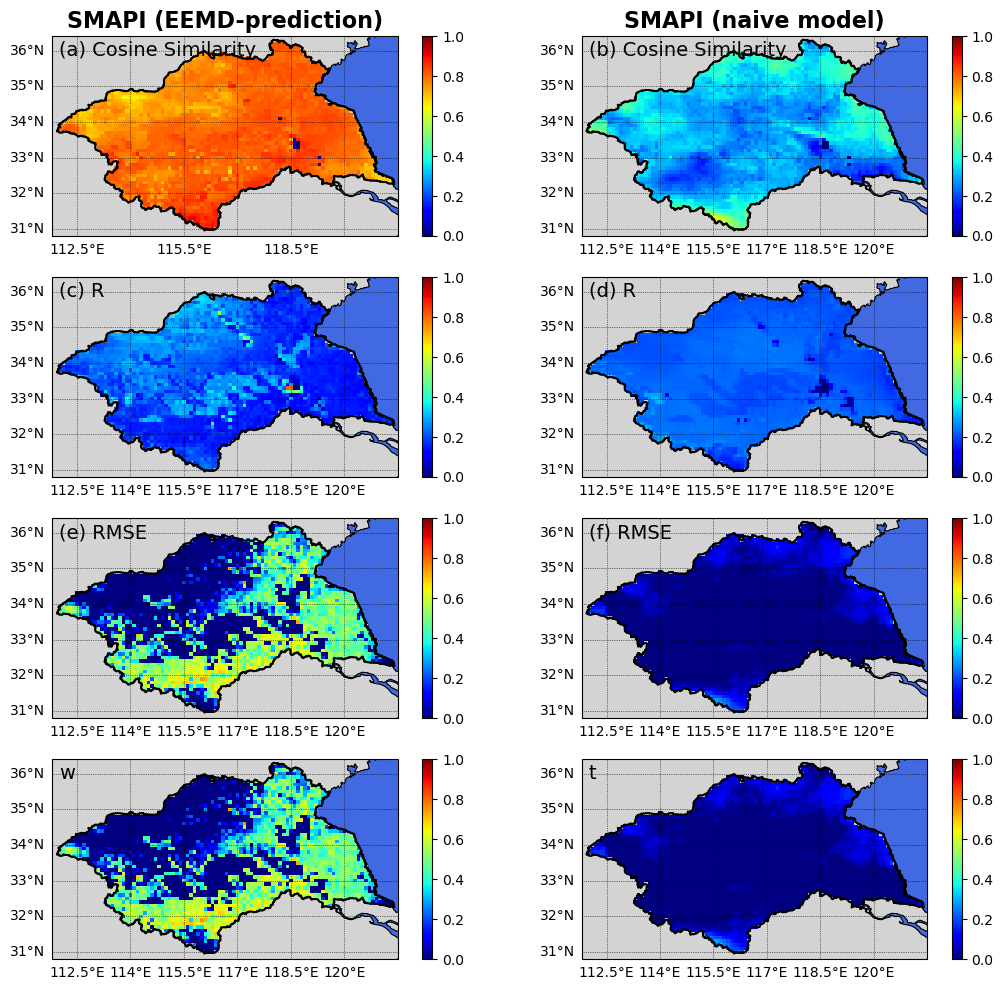

In [33]:
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy as ctp
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
lat = smi_imf.lat.values[:,0]
lon = smi_imf.lon.values[0,:]


fig = plt.figure(figsize = [12,10])
plt.subplots_adjust(wspace=0.025,hspace=0.1)
fig_L = np.array([1,3,5,7])
fig_R = np.array([2,4,6,8])
label_L = ['(a) Cosine Similarity','(c) R', '(e) RMSE','w']
label_R = ['(b) Cosine Similarity','(d) R', '(f) RMSE','t']

for ii in range(4):
#     index = xr.DataArray(data = basic_idx1[ii,:,:], 
#                          dims = {'x','y'},
#                          coords={'y':lon,'x':lat})
    index = xr.DataArray(data = basic_idx1[ii,:,:], 
                             coords={'y':lat,
                                     'x':lon},
                             dims = {'y','x'})
    figaxi = fig.add_subplot(4,2,fig_L[ii], projection = ccrs.PlateCarree())
    figaxi.add_feature(ctp.feature.LAND, edgecolor='black', zorder = 0,lw = 0.2, facecolor = 'lightgrey')
    figaxi.add_feature(ctp.feature.OCEAN, zorder = 0, facecolor = 'royalblue')
    figaxi.coastlines(zorder=0, lw= 0.8)
    figtmp = index.plot(ax = figaxi,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False,
                        cmap = 'jet',
                        vmax = 1,
                        vmin = 0,)
    figaxi.set_aspect('equal')
    plt.colorbar(figtmp,fraction=0.026, pad=0.04)
    plt.plot(x,y,'k')
    gl=figaxi.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = ticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    plt.axis([111.8,121.5,30.8,36.4])
    plt.tight_layout()
    figaxi.text(112, 35.85, label_L[ii],fontsize = 14)
    if ii ==0:
        plt.title('SMAPI (EEMD-prediction)',fontsize = 16, weight='bold')
    #----------------------------------------------------------------#
    #----------------------------------------------------------------#
    index = xr.DataArray(data = basic_idx2[ii,:,:], 
                         coords={'y':lat,
                                 'x':lon},
                         dims = {'y','x'})
#     index = xr.DataArray(data = basic_idx2[ii,:,:], 
#                          dims = {'x','y'},
#                          coords={'y':lon,'x':lat})
    figaxi = fig.add_subplot(4,2,fig_R[ii], projection = ccrs.PlateCarree())
    figaxi.add_feature(ctp.feature.LAND, edgecolor='black', zorder = 0,lw = 0.2, facecolor = 'lightgrey')
    figaxi.add_feature(ctp.feature.OCEAN, zorder = 0, facecolor = 'royalblue')
    figaxi.coastlines(zorder=0, lw= 0.8)
    figtmp = index.plot(ax = figaxi,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False,
                        cmap = 'jet',
                        vmax = 1,
                        vmin = 0,)
                       #levels = [0,0.2,0.4,0.6,0.8,1])
    figaxi.set_aspect('equal')
    figaxi.text(112, 35.85, label_R[ii],fontsize = 14)
    gl=figaxi.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = ticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    plt.axis([111.8,121.5,30.8,36.4])
    plt.colorbar(figtmp,fraction=0.026, pad=0.04)
    plt.plot(x,y,'k')
    plt.tight_layout()
    if ii ==0:
        plt.title('SMAPI (naive model)',fontsize = 16, weight='bold')
# plt.savefig(r'E:\jupyter_output_figs\metrics_self2eemd\basic_metrics_HRB_v1.png',
#            bbox_inches = 'tight',
#            pad_inches = 0.05,
#            dpi = 600)
# ax1 = fig.add_subplot(3,2,1)
# ax1.text(111.8,121.5,'asd')
#figaxi.text(112, 35.85, label_R[ii],fontsize = 14)
# fig.subplots_adjust(bottom=0.15)
# cbar_ax = fig.add_axes([0.14, 0.25, 0.75, 0.03])
# fig.colorbar(figtmp, cax=cbar_ax, orientation = 'horizontal')

In [26]:
def class_smapi(smi):
    # 对干旱指标进行分级
    # 低于-0.05即出现干旱情形
    # 低于-0.15即出现中度干旱
    # 低于-0.3即出现重度干旱
    smi_mild = np.where((smi > -0.05) | (smi <= -0.15), 0, smi)
    smi_mild = np.where((smi_mild <= -0.05) & (smi_mild > -0.15), 1, smi_mild)

    smi_moderate = np.where((smi > -0.15) | (smi <= -0.3), 0, smi)
    smi_moderate = np.where((smi_moderate <= -0.15) & (smi_moderate > -0.3), 1, smi_moderate)

    smi_severe = np.where(smi > -0.3, 0, smi)
    smi_severe = np.where(smi_severe <= -0.3, 1, smi_severe)
    
    return smi_mild, smi_moderate, smi_severe

In [27]:
true_L1, true_L2, true_L3 = class_smapi(dt_true)
imf_L1, imf_L2, imf_L3 = class_smapi(dt_imf)
self_L1, self_L2, self_L3 = class_smapi(dt_self)

In [28]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    acc = (TP+TN)/(TP+TN+FP+FN)
    
    
    error = (FP+FN)/(TP+TN+FP+FN)
    
    try:
        miss = FN/(TN+FP)
        pod = TP/(TP+FN)
        far = FP/(TP+FP)
    except ZeroDivisionError:
        miss = 0
        pod = 0
        far = 0
    return(acc,far,miss,error,pod)

In [29]:
def category_idx(dt_true,dt_imf,dt_self):
    metrics1 = np.zeros([dt_true.shape[1],dt_true.shape[2],5])*np.nan
    metrics2 = np.zeros([dt_true.shape[1],dt_true.shape[2],5])*np.nan
    for ii in tqdm(range(dt_true.shape[1])):
        for jj in range(dt_true.shape[2]):
            #print(ii,jj)
            med_val = dt_true[:,ii,jj]
            med_fct1 = dt_imf[:,ii,jj]
            med_fct2 = dt_self[:,ii,jj]
            if np.isnan(med_val).all() == True:
                metrics1[ii,jj,:] = np.zeros(5) * np.nan
                metrics2[ii,jj,:] = np.zeros(5) * np.nan
            else:
                med_idx1 = perf_measure(med_val,med_fct1)
                med_idx2 = perf_measure(med_val,med_fct2)
                for kk in range(5):
                    metrics1[ii,jj,kk] = med_idx1[kk]
                    metrics2[ii,jj,kk] = med_idx2[kk]
    return metrics1, metrics2

In [60]:
L1_ctg_idx1, L1_ctg_idx2 =  category_idx(true_L1, imf_L1, self_L1)
L2_ctg_idx1, L2_ctg_idx2 =  category_idx(true_L2, imf_L2, self_L2)
L3_ctg_idx1, L3_ctg_idx2 =  category_idx(true_L3, imf_L3, self_L3)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

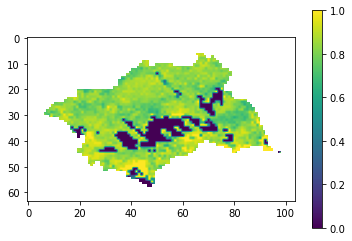

In [66]:
plt.imshow(L1_ctg_idx2[:,:,1])
plt.colorbar()

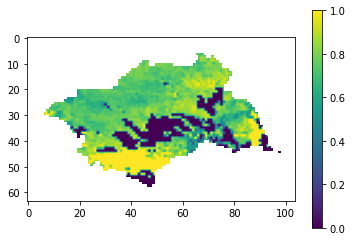

In [65]:
plt.imshow(L2_ctg_idx2[:,:,1])
plt.colorbar()

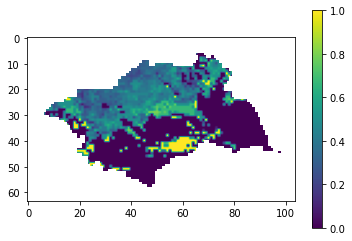

In [64]:
plt.imshow(L3_ctg_idx2[:,:,1])
plt.colorbar()

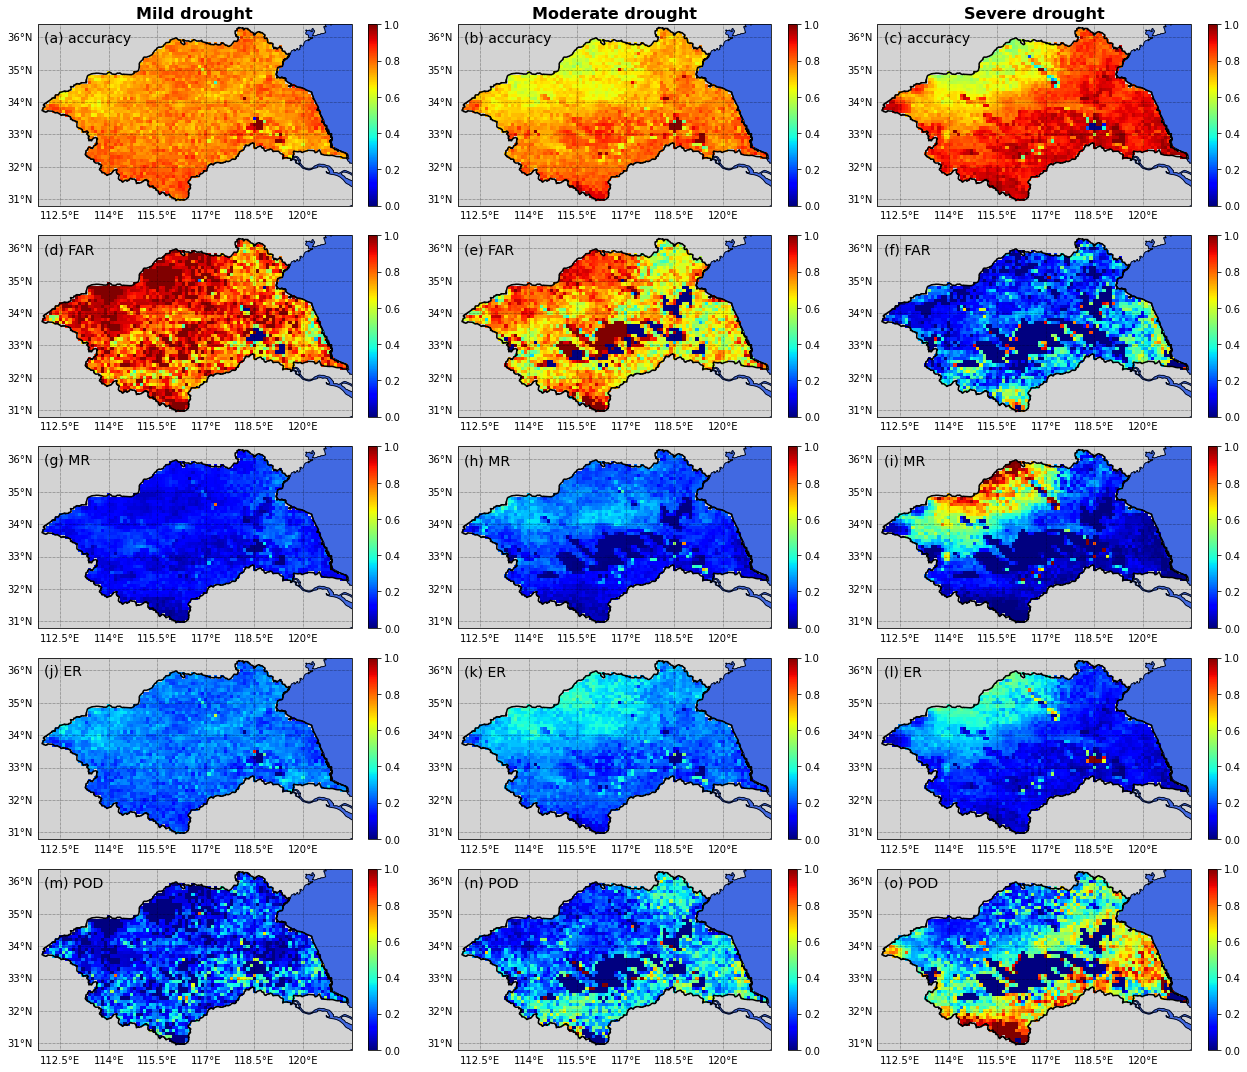

In [68]:
fig = plt.figure(figsize = [18,15])
plt.subplots_adjust(wspace=0.025,hspace=0.1)
fig_1 = np.arange(1,14,3)
fig_2 = np.arange(2,15,3)
fig_3 = np.arange(3,16,3)
label_1 = ['(a) accuracy','(d) FAR', '(g) MR','(j) ER','(m) POD']
label_2 = ['(b) accuracy','(e) FAR', '(h) MR','(k) ER','(n) POD']
label_3 = ['(c) accuracy','(f) FAR', '(i) MR','(l) ER','(o) POD']
idx1 = L1_ctg_idx1
idx2 = L2_ctg_idx1
idx3 = L3_ctg_idx1
subtitle = ['Mild drought','Moderate drought','Severe drought']
for ii in range(5):
    index1 = xr.DataArray(data = idx1[:,:,ii], 
                         dims = {'x','y'},
                         coords={'y':lon,'x':lat})
#     index = xr.DataArray(data = idx1[:,:,ii], 
#                          coords={'lati':lat,
#                                  'long':lon},
#                          dims = {'lati','long'})
    figaxi = fig.add_subplot(5,3,fig_1[ii], projection = ccrs.PlateCarree())
    figaxi.add_feature(ctp.feature.LAND, edgecolor='black', zorder = 0,lw = 0.2, facecolor = 'lightgrey')
    figaxi.add_feature(ctp.feature.OCEAN, zorder = 0, facecolor = 'royalblue')
    figaxi.coastlines(zorder=0, lw= 0.8)
    figtmp = index1.plot(ax = figaxi,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False,
                        cmap = 'jet',
                        vmax = 1,
                        vmin = 0,)
    figaxi.set_aspect('equal')
    plt.colorbar(figtmp,fraction=0.026, pad=0.04)
    plt.plot(x,y,'k')
    gl=figaxi.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = ticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    plt.axis([111.8,121.5,30.8,36.4])
    plt.tight_layout()
    figaxi.text(112, 35.85, label_1[ii],fontsize = 14)
    if ii ==0:
        plt.title(subtitle[0],fontsize = 16, weight='bold')
    #----------------------------------------------------------------#
    #----------------------------------------------------------------#
    index2 = xr.DataArray(data = idx2[:,:,ii], 
                         coords={'lati':lat,
                                 'long':lon},
                         dims = {'long','lati'})
#     xr.DataArray(data = idx2[:,:,ii], 
#                          dims = {'x','y'},
#                          coords={'y':lon,'x':lat})
    
    figaxi = fig.add_subplot(5,3,fig_2[ii], projection = ccrs.PlateCarree())
    figaxi.add_feature(ctp.feature.LAND, edgecolor='black', zorder = 0,lw = 0.2, facecolor = 'lightgrey')
    figaxi.add_feature(ctp.feature.OCEAN, zorder = 0, facecolor = 'royalblue')
    figaxi.coastlines(zorder=0, lw= 0.8)
    figtmp = index2.plot(ax = figaxi,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False,
                        cmap = 'jet',
                        vmax = 1,
                        vmin = 0,)
                       #levels = [0,0.2,0.4,0.6,0.8,1])
    figaxi.set_aspect('equal')
    figaxi.text(112, 35.85, label_2[ii],fontsize = 14)
    gl=figaxi.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = ticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    plt.axis([111.8,121.5,30.8,36.4])
    plt.colorbar(figtmp,fraction=0.026, pad=0.04)
    plt.plot(x,y,'k')
    plt.tight_layout()
    if ii ==0:
        plt.title(subtitle[1],fontsize = 16, weight='bold')
    #----------------------------------------------------------------#
    #----------------------------------------------------------------#
    index3 = xr.DataArray(data = idx3[:,:,ii], 
                         dims = {'x','y'},
                         coords={'y':lon,'x':lat})
#     xr.DataArray(data = idx3[:,:,ii], 
#                          coords={'lati':lat,
#                                  'long':lon},
#                          dims = {'lati','long'})
    figaxi = fig.add_subplot(5,3,fig_3[ii], projection = ccrs.PlateCarree())
    figaxi.add_feature(ctp.feature.LAND, edgecolor='black', zorder = 0,lw = 0.2, facecolor = 'lightgrey')
    figaxi.add_feature(ctp.feature.OCEAN, zorder = 0, facecolor = 'royalblue')
    figaxi.coastlines(zorder=0, lw= 0.8)
    figtmp = index3.plot(ax = figaxi,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False,
                        cmap = 'jet',
                        vmax = 1,
                        vmin = 0,)
                       #levels = [0,0.2,0.4,0.6,0.8,1])
    figaxi.set_aspect('equal')
    figaxi.text(112, 35.85, label_3[ii],fontsize = 14)
    gl=figaxi.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = ticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    plt.axis([111.8,121.5,30.8,36.4])
    plt.colorbar(figtmp,fraction=0.026, pad=0.04)
    plt.plot(x,y,'k')
    plt.tight_layout()
    if ii ==0:
        plt.title(subtitle[2],fontsize = 16, weight='bold')
# plt.savefig(r'E:\jupyter_output_figs\metrics_self2eemd\category_metrics_imffct_HRB_v1.png',
#            bbox_inches = 'tight',
#            pad_inches = 0.05,
#            dpi = 600)

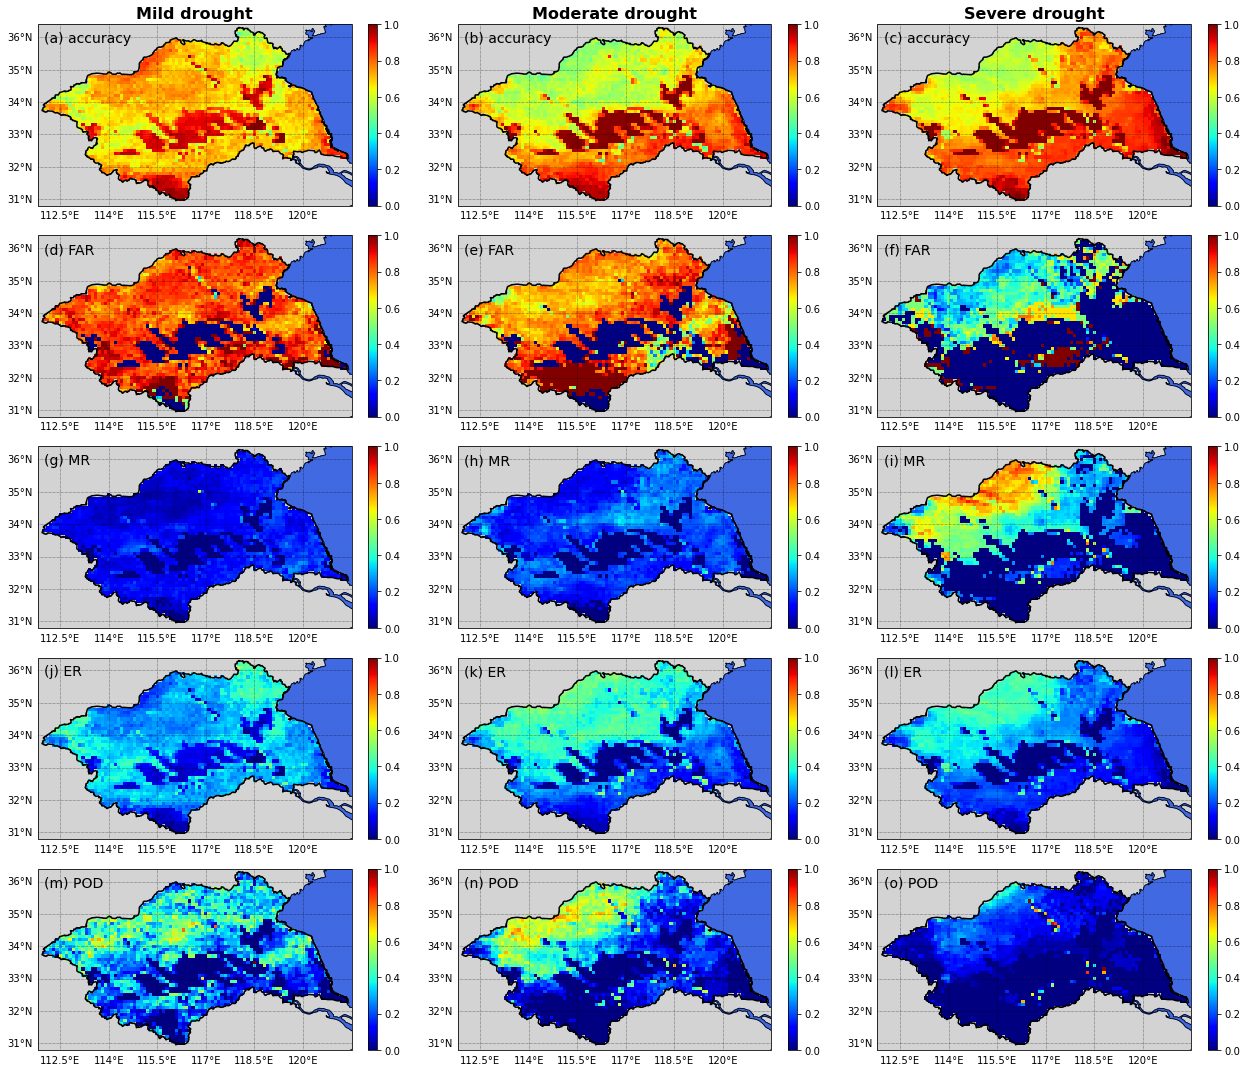

In [70]:
fig = plt.figure(figsize = [18,15])
plt.subplots_adjust(wspace=0.025,hspace=0.1)
fig_1 = np.arange(1,14,3)
fig_2 = np.arange(2,15,3)
fig_3 = np.arange(3,16,3)
label_1 = ['(a) accuracy','(d) FAR', '(g) MR','(j) ER','(m) POD']
label_2 = ['(b) accuracy','(e) FAR', '(h) MR','(k) ER','(n) POD']
label_3 = ['(c) accuracy','(f) FAR', '(i) MR','(l) ER','(o) POD']
idx1 = L1_ctg_idx2
idx2 = L2_ctg_idx2
idx3 = L3_ctg_idx2
subtitle = ['Mild drought','Moderate drought','Severe drought']
for ii in range(5):
#     index = xr.DataArray(data = idx1[:,:,ii], 
#                          dims = {'x','y'},
#                          coords={'y':lon,'x':lat})
    index1 = xr.DataArray(data = idx1[:,:,ii], 
                         coords={'lat':lat,
                                 'lon':lon},
                         dims = {'lat','lon'})
    figaxi = fig.add_subplot(5,3,fig_1[ii], projection = ccrs.PlateCarree())
    figaxi.add_feature(ctp.feature.LAND, edgecolor='black', zorder = 0,lw = 0.2, facecolor = 'lightgrey')
    figaxi.add_feature(ctp.feature.OCEAN, zorder = 0, facecolor = 'royalblue')
    figaxi.coastlines(zorder=0, lw= 0.8)
    figtmp = index1.plot(ax = figaxi,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False,
                        cmap = 'jet',
                        vmax = 1,
                        vmin = 0,)
    figaxi.set_aspect('equal')
    plt.colorbar(figtmp,fraction=0.026, pad=0.04)
    plt.plot(x,y,'k')
    gl=figaxi.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = ticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    plt.axis([111.8,121.5,30.8,36.4])
    plt.tight_layout()
    figaxi.text(112, 35.85, label_1[ii],fontsize = 14)
    if ii ==0:
        plt.title(subtitle[0],fontsize = 16, weight='bold')
    #----------------------------------------------------------------#
    #----------------------------------------------------------------#
    index2 = xr.DataArray(data = idx2[:,:,ii], 
                         coords={'lat':lat,
                                 'lon':lon},
                         dims = {'lon','lat'})
#     xr.DataArray(data = idx2[:,:,ii], 
#                          dims = {'x','y'},
#                          coords={'y':lon,'x':lat})
    
    figaxi = fig.add_subplot(5,3,fig_2[ii], projection = ccrs.PlateCarree())
    figaxi.add_feature(ctp.feature.LAND, edgecolor='black', zorder = 0,lw = 0.2, facecolor = 'lightgrey')
    figaxi.add_feature(ctp.feature.OCEAN, zorder = 0, facecolor = 'royalblue')
    figaxi.coastlines(zorder=0, lw= 0.8)
    figtmp = index2.plot(ax = figaxi,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False,
                        cmap = 'jet',
                        vmax = 1,
                        vmin = 0,)
                       #levels = [0,0.2,0.4,0.6,0.8,1])
    figaxi.set_aspect('equal')
    figaxi.text(112, 35.85, label_2[ii],fontsize = 14)
    gl=figaxi.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = ticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    plt.axis([111.8,121.5,30.8,36.4])
    plt.colorbar(figtmp,fraction=0.026, pad=0.04)
    plt.plot(x,y,'k')
    plt.tight_layout()
    if ii ==0:
        plt.title(subtitle[1],fontsize = 16, weight='bold')
    #----------------------------------------------------------------#
    #----------------------------------------------------------------#
#     index = xr.DataArray(data = idx3[:,:,ii], 
#                          dims = {'x','y'},
#                          coords={'y':lon,'x':lat})
    index3 = xr.DataArray(data = idx3[:,:,ii], 
                         coords={'lat':lat,
                                 'lon':lon},
                         dims = {'lat','lon'})
    figaxi = fig.add_subplot(5,3,fig_3[ii], projection = ccrs.PlateCarree())
    figaxi.add_feature(ctp.feature.LAND, edgecolor='black', zorder = 0,lw = 0.2, facecolor = 'lightgrey')
    figaxi.add_feature(ctp.feature.OCEAN, zorder = 0, facecolor = 'royalblue')
    figaxi.coastlines(zorder=0, lw= 0.8)
    figtmp = index3.plot(ax = figaxi,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False,
                        cmap = 'jet',
                        vmax = 1,
                        vmin = 0,)
                       #levels = [0,0.2,0.4,0.6,0.8,1])
    figaxi.set_aspect('equal')
    figaxi.text(112, 35.85, label_3[ii],fontsize = 14)
    gl=figaxi.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = ticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    plt.axis([111.8,121.5,30.8,36.4])
    plt.colorbar(figtmp,fraction=0.026, pad=0.04)
    plt.plot(x,y,'k')
    plt.tight_layout()
    if ii ==0:
        plt.title(subtitle[2],fontsize = 16, weight='bold')
plt.savefig(r'E:\jupyter_output_figs\metrics_self2eemd\category_metrics_selffct_HRB_v1.png',
           bbox_inches = 'tight',
           pad_inches = 0.05,
           dpi = 600)

In [36]:
np.count_nonzero(~np.isnan(idx1[:,:,1]))

2597

In [ ]:
# Daily frequency map
# -0.05~-0.15
# -0.15~-0.3
# <-0.3

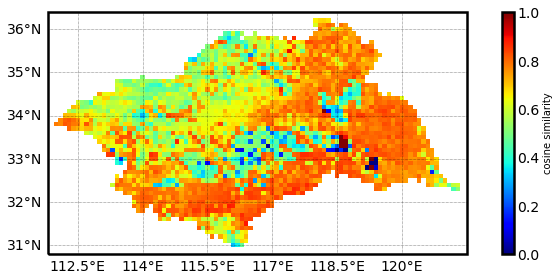

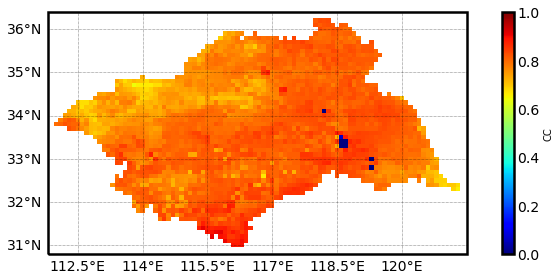

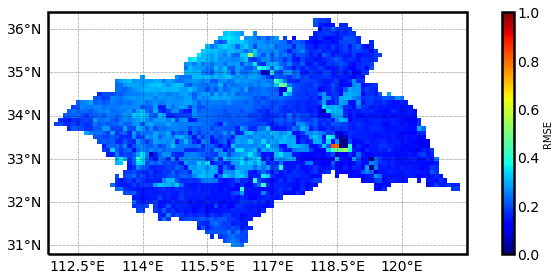

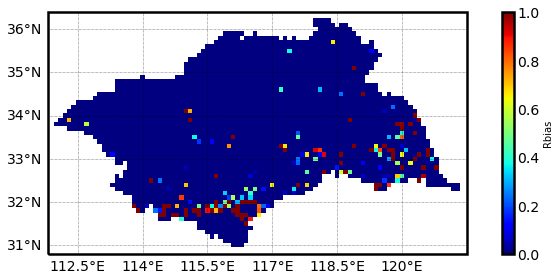

In [50]:
# return(acc,far,miss,error,pod)
sub_idx = ['cosine similarity','CC','RMSE','Rbias']
for ii in range (4):
    plot_hrb(smi_imf,basic_idx1
             [ii,:,:],sub_idx[ii])

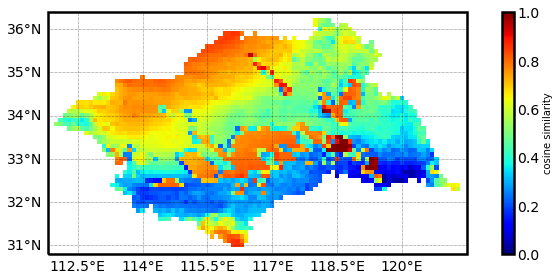

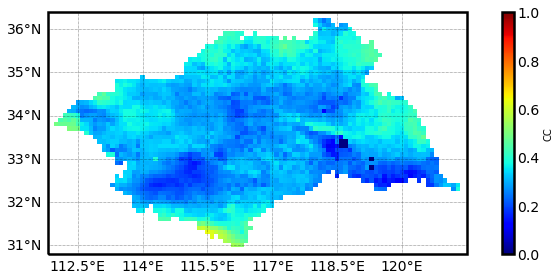

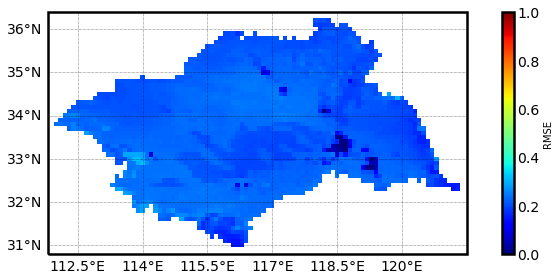

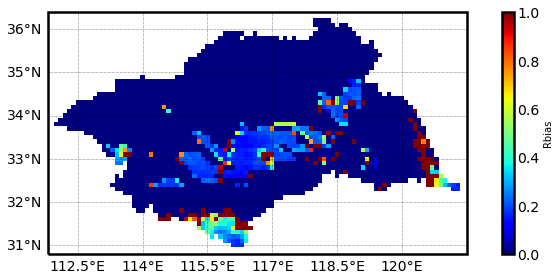

In [52]:
# return(acc,far,miss,error,pod)
sub_idx = ['cosine similarity','CC','RMSE','Rbias']
for ii in range (4):
    plot_hrb(smi_self,basic_idx2
             [ii,:,:],sub_idx[ii])

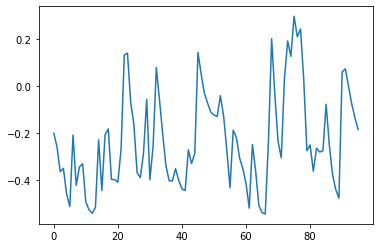

In [11]:
plt.plot(dt_true[:,25,26])

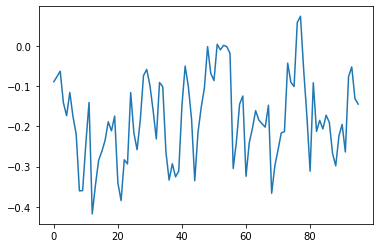

In [12]:
plt.plot(dt_self[:,25,26])

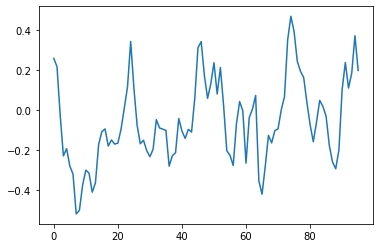

In [13]:
plt.plot(dt_imf[:,25,26])

In [14]:
smi = dt_true.copy()

smi_mild = np.where(smi > -0.05, 0, smi)
smi_mild = np.where(smi_mild <= -0.05, 1, smi_mild)

smi_moderate = np.where(smi > -0.15, 0, smi)
smi_moderate = np.where(smi_moderate <= -0.15, 1, smi_moderate)

smi_severe = np.where(smi > -0.15, 0, smi)
smi_severe = np.where(smi_severe <= -0.15, 1, smi_severe)

In [73]:
def class_smapi(smi):
    # 对干旱指标进行分级
    # 低于-0.05即出现干旱情形
    # 低于-0.15即出现中度干旱
    # 低于-0.3即出现重度干旱
    smi_mild = np.where(smi > -0.05, 0, smi)
    smi_mild = np.where(smi_mild <= -0.05, 1, smi_mild)

    smi_moderate = np.where(smi > -0.15, 0, smi)
    smi_moderate = np.where(smi_moderate <= -0.15, 1, smi_moderate)

    smi_severe = np.where(smi > -0.15, 0, smi)
    smi_severe = np.where(smi_severe <= -0.15, 1, smi_severe)
    
    return smi_mild, smi_moderate, smi_severe

In [74]:
true_L1, true_L2, true_L3 = class_smapi(dt_true)
imf_L1, imf_L2, imf_L3 = class_smapi(dt_imf)
self_L1, self_L2, self_L3 = class_smapi(dt_self)

In [75]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    acc = (TP+TN)/(TP+TN+FP+FN)
    
    
    error = (FP+FN)/(TP+TN+FP+FN)
    
    try:
        miss = FN/(TP+FN)
        pod = TP/(TP+FN)
        far = FP/(TP+FP)
    except ZeroDivisionError:
        miss = 0
        pod = 0
        far = 0
    return(acc,far,miss,error,pod)

In [81]:
def category_idx(dt_true,dt_imf,dt_self):
    metrics1 = np.zeros([dt_true.shape[1],dt_true.shape[2],5])*np.nan
    metrics2 = np.zeros([dt_true.shape[1],dt_true.shape[2],5])*np.nan
    for ii in tqdm(range(dt_true.shape[1])):
        for jj in range(dt_true.shape[2]):
            #print(ii,jj)
            med_val = dt_true[:,ii,jj]
            med_fct1 = dt_imf[:,ii,jj]
            med_fct2 = dt_self[:,ii,jj]
            if np.isnan(med_val).all() == True:
                metrics1[ii,jj,:] = np.zeros(5) * np.nan
                metrics2[ii,jj,:] = np.zeros(5) * np.nan
            else:
                med_idx1 = perf_measure(med_val,med_fct1)
                med_idx2 = perf_measure(med_val,med_fct2)
                for kk in range(5):
                    metrics1[ii,jj,kk] = med_idx1[kk]
                    metrics2[ii,jj,kk] = med_idx2[kk]
    return metrics1, metrics2

In [82]:
L1_ctg_idx1, L1_ctg_idx2 =  category_idx(true_L1, imf_L1, self_L1)
L2_ctg_idx1, L2_ctg_idx2 =  category_idx(true_L2, imf_L2, self_L2)
L3_ctg_idx1, L3_ctg_idx2 =  category_idx(true_L3, imf_L3, self_L3)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import os
def plot_hrb(data,idx_matrix, label_title,ax):
    fig = plt.figure(figsize=(10, 4))
    ax.plt.rcParams['axes.linewidth'] = 2.5
    ax.plt.subplot(projection=ccrs.PlateCarree())
    # plt.title('From '+str(df_predict.loc['TARGET'].index[0])[0:10]+' to '+
    #           str(df_predict.loc['TARGET'].index[-1])[0:10], fontsize=16, weight='bold')
    cmap = plt.get_cmap('jet')
    dtplot = plt.pcolormesh(data.lon.values,data.lat.values,idx_matrix,cmap=cmap,vmin = 0,vmax =1)
    #plt.plot(x,y,c='k')
    cbar = plt.colorbar(dtplot, label=label_title)
    cbar.ax.axes.tick_params(length=0)
    cbar.ax.tick_params(labelsize=14)
    ax.set_aspect('equal')
    gl=ax.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = mticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    plt.axis([111.8,121.5,30.8,36.4])
    plt.tight_layout()
    #plt.save('E:\\jupyter_output_figs\\val_metrics\\'+label_title+'.png')

AttributeError: 'numpy.ndarray' object has no attribute 'get_cmap'

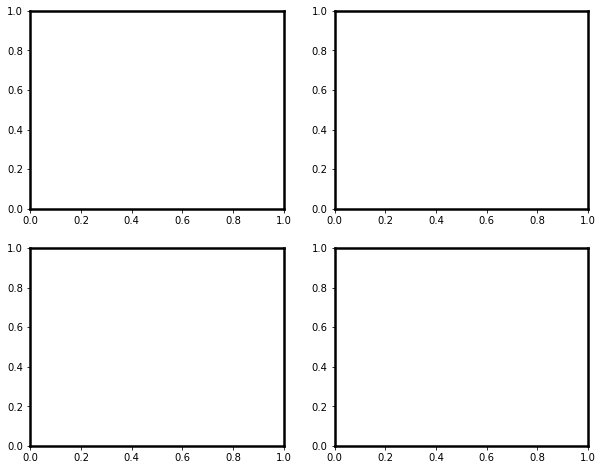

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax = axes.flatten()
data = smi_imf
idx_matrix = L1_ctg_idx1[:,:,1]
label_title = 'test'
# ax.plt.rcParams['axes.linewidth'] = 2.5
# ax.plt.subplot(projection=ccrs.PlateCarree())
# # plt.title('From '+str(df_predict.loc['TARGET'].index[0])[0:10]+' to '+
# #           str(df_predict.loc['TARGET'].index[-1])[0:10], fontsize=16, weight='bold')
ax.get_cmap('jet')
ax.pcolormesh(data.lon.values,data.lat.values,idx_matrix,cmap=cmap,vmin = 0,vmax =1)
#plt.plot(x,y,c='k')
cbar = plt.colorbar(dtplot, label=label_title)
cbar.ax.axes.tick_params(length=0)
cbar.ax.tick_params(labelsize=14)
ax.set_aspect('equal')
gl=ax.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
gl.top_labels=False #关闭上部经纬标签                                  
gl.right_labels=False
gl.ylocator = mticker.FixedLocator(np.arange(31,37.5,1))
gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
gl.yformatter = LATITUDE_FORMATTER  
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
plt.axis([111.8,121.5,30.8,36.4])
plt.tight_layout()

In [ ]:
def plot_graph(data, ax):
    name = data[0]
    X = data[1]
    Y = data[2]

    #first line
    ax.plot([X[0],X[-1]],[Y[0],Y[-1]+20], marker='o', label='Line 1')

    #second line
    ax.plot(X,Y,marker='o',label='Line 2')

    #axis settings
    ax.set_ylim([0,80])
    ax.invert_yaxis()
    ax.set_title('My Graph')
    for x,y in zip(X,Y): ax.annotate(y,(x,y-4))
    ax.legend(loc=8)





In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, axe in enumerate(axes):
    plot_graph(data=patient[i], ax=axe)

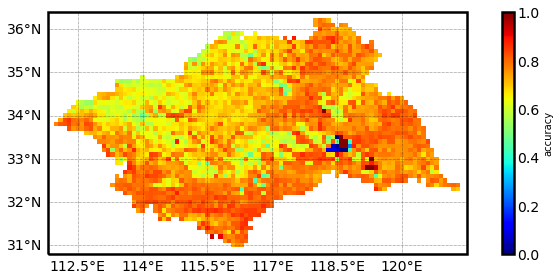

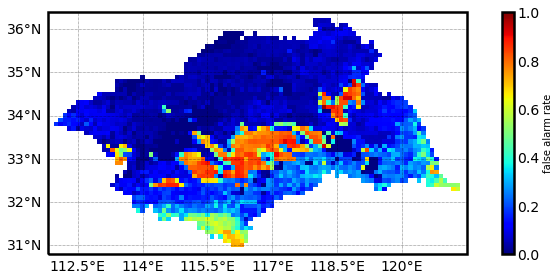

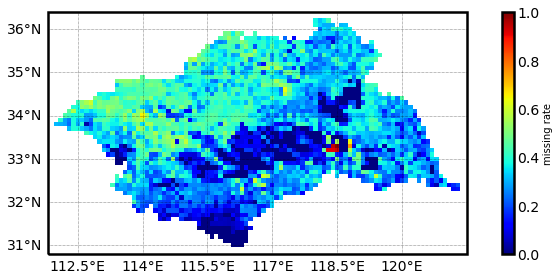

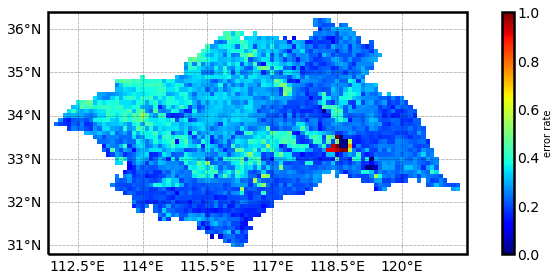

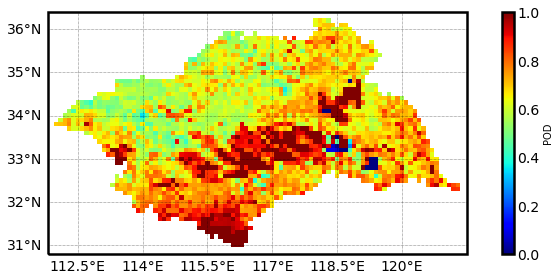

In [83]:
# return(acc,far,miss,error,pod)
sub_idx = ['accuracy','false alarm rate','missing rate','error rate','POD']
for ii in range (5):
    plot_hrb(smi_imf,L1_ctg_idx1
             [:,:,ii],sub_idx[ii])

In [76]:
# metrics-[accuracy, false alarm rate. missing rate, error rate, probability of detecton]
dt_true = true_L1
dt_imf = imf_L1
dt_self = self_L1

metrics1 = np.zeros([dt_true.shape[1],dt_true.shape[2],5])*np.nan
metrics2 = np.zeros([dt_true.shape[1],dt_true.shape[2],5])*np.nan
for ii in tqdm(range(dt_true.shape[1])):
    for jj in range(dt_true.shape[2]):
        #print(ii,jj)
        med_val = dt_true[:,ii,jj]
        med_fct1 = dt_imf[:,ii,jj]
        med_fct2 = dt_self[:,ii,jj]
        if np.isnan(med_val).all() == True:
            metrics1[ii,jj,:] = np.zeros(5) * np.nan
            metrics2[ii,jj,:] = np.zeros(5) * np.nan
        else:
            med_idx1 = perf_measure(med_val,med_fct1)
            med_idx2 = perf_measure(med_val,med_fct2)
            for kk in range(5):
                metrics1[ii,jj,kk] = med_idx1[kk]
                metrics2[ii,jj,kk] = med_idx2[kk]

  0%|          | 0/64 [00:00<?, ?it/s]

In [77]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import os
def plot_hrb(data,idx_matrix, label_title):
    fig = plt.figure(figsize=(10, 4))
    plt.rcParams['axes.linewidth'] = 2.5
    ax = plt.subplot(projection=ccrs.PlateCarree())
    # plt.title('From '+str(df_predict.loc['TARGET'].index[0])[0:10]+' to '+
    #           str(df_predict.loc['TARGET'].index[-1])[0:10], fontsize=16, weight='bold')
    cmap = plt.get_cmap('jet')
    dtplot = plt.pcolormesh(data.lon.values,data.lat.values,idx_matrix,cmap=cmap,vmin = 0,vmax =1)
    #plt.plot(x,y,c='k')
    cbar = plt.colorbar(dtplot, label=label_title)
    cbar.ax.axes.tick_params(length=0)
    cbar.ax.tick_params(labelsize=14)
    ax.set_aspect('equal')
    gl=ax.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
    gl.top_labels=False #关闭上部经纬标签                                  
    gl.right_labels=False
    gl.ylocator = mticker.FixedLocator(np.arange(31,37.5,1))
    gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
    gl.yformatter = LATITUDE_FORMATTER  
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    plt.axis([111.8,121.5,30.8,36.4])
    plt.tight_layout()

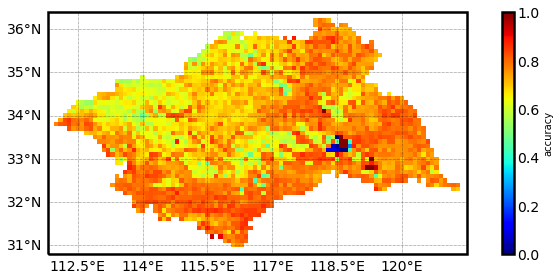

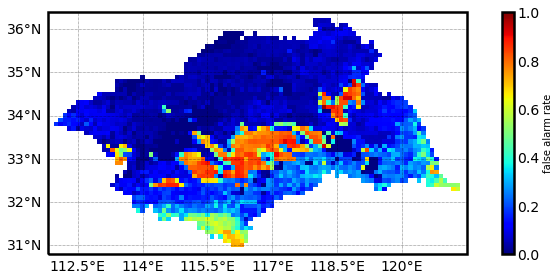

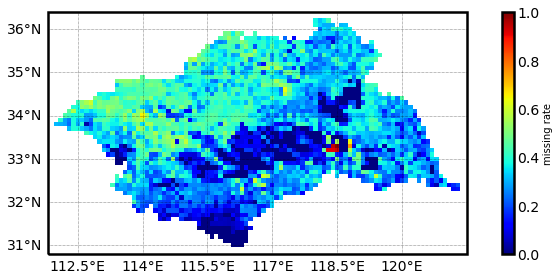

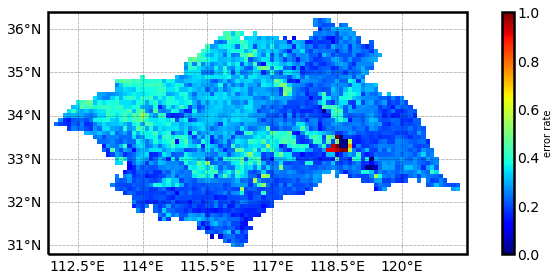

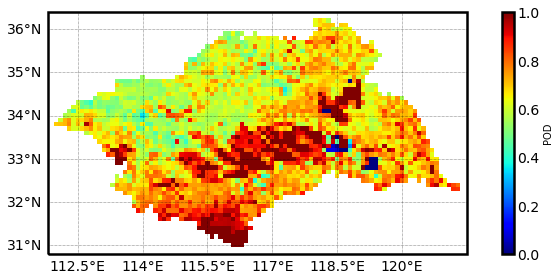

In [78]:
# return(acc,far,miss,error,pod)
sub_idx = ['accuracy','false alarm rate','missing rate','error rate','POD']
for ii in range (5):
    plot_hrb(smi_imf,metrics1
             [:,:,ii],sub_idx[ii])

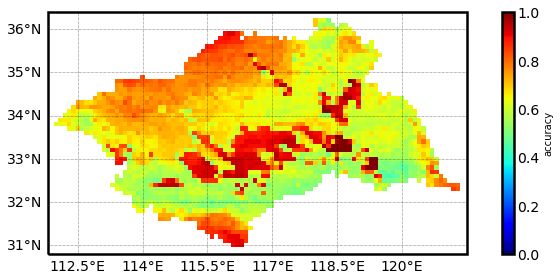

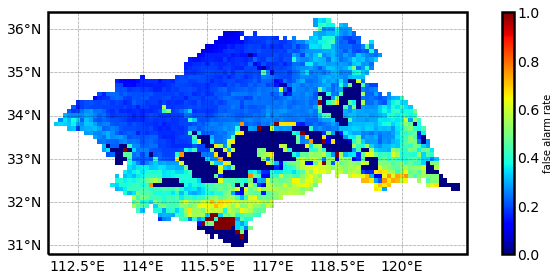

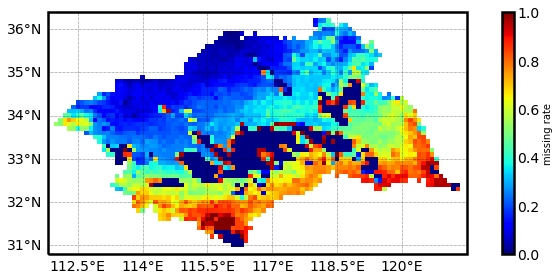

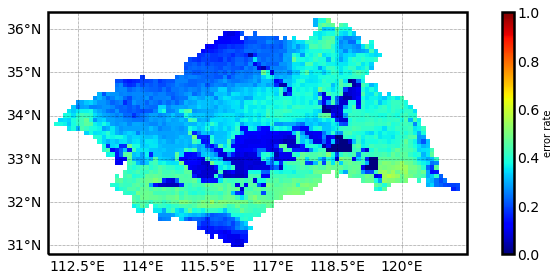

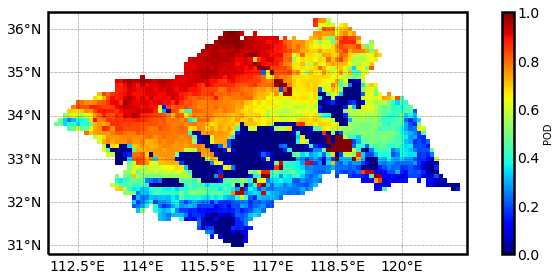

In [79]:
# return(acc,far,miss,error,pod)
sub_idx = ['accuracy','false alarm rate','missing rate','error rate','POD']
for ii in range (5):
    plot_hrb(smi_imf,metrics2[:,:,ii],sub_idx[ii])

In [ ]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import os

data = med_df
fig = plt.figure(figsize=(10, 4))
plt.rcParams['axes.linewidth'] = 2.5
ax = plt.subplot(projection=ccrs.PlateCarree())
# plt.title('From '+str(df_predict.loc['TARGET'].index[0])[0:10]+' to '+
#           str(df_predict.loc['TARGET'].index[-1])[0:10], fontsize=16, weight='bold')

cmap = plt.get_cmap('jet')
dtplot = plt.pcolormesh(data.lon.values,data.lat.values,sum_imf[3,:,:],cmap=cmap)#,vmin = -1,vmax =1)
#plt.plot(x,y,c='k')
cbar = plt.colorbar(dtplot, label='SMAPI')
cbar.ax.axes.tick_params(length=0)
cbar.ax.tick_params(labelsize=14)
ax.set_aspect('equal')
gl=ax.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
gl.top_labels=False #关闭上部经纬标签                                  
gl.right_labels=False
gl.ylocator = mticker.FixedLocator(np.arange(31,37.5,1))
gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
gl.yformatter = LATITUDE_FORMATTER  
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
plt.axis([111.8,121.5,30.8,36.4])
plt.tight_layout()

In [10]:
import xskillscore as xs
import matplotlib.pyplot as plt

In [11]:
obs = xr.DataArray(
       dt_true,
       coords=[
           xr.cftime_range("2019-03-03", "2020-12-27", freq="7D"),
           smi_true.lat.values[:,1],
           smi_true.lon.values[1,:],
       ],
       dims=["time", "lat", "lon"],
    )



fct1 = xr.DataArray(
       dt_imf,
       coords=[
           xr.cftime_range("2019-03-03", "2020-12-27", freq="7D"),
           smi_true.lat.values[:,1],
           smi_true.lon.values[1,:],
       ],
       dims=["time", "lat", "lon"],
    )

fct2 = xr.DataArray(
       dt_self,
       coords=[
           xr.cftime_range("2019-03-03", "2020-12-27", freq="7D"),
           smi_true.lat.values[:,1],
           smi_true.lon.values[1,:],
       ],
       dims=["time", "lat", "lon"],
    )

In [12]:
from xskillscore import Contingency

In [21]:
np.array([0, 0.5, 1]).shape

(3,)

In [22]:
np.linspace(0, 1, 2)

array([0., 1.])

In [30]:
o_category_edges = np.linspace(0, 2, 2)
f_category_edges = np.linspace(0, 2, 2)
dichotomous_contingency = Contingency(obs, fct1,o_category_edges,f_category_edges,dim='time')
dichotomous_contingency

<xskillscore.Contingency>
                                                      observations_category: 1,
                                                      forecasts_category: 1)>
array([[[[0]],

        [[0]],

        [[0]],

        ...,

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],
...
        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],

        ...,

        [[0]],

        [[0]],

        [[0]]]], dtype=int64)
Coordinates:
  * lat                           (lat) float32 36.8 36.7 36.6 ... 30.6 30.5
  * lon                           (lon) float32 111.5 111.6 ... 121.7 121.8
    observations_category_bounds  (observations_category) <U10 '[0.0, 2.0]'
    forecasts_category_bounds     (forecasts_category) <U10 '[0.0, 2.0]'
  * observations_category         (observations_category) int32 1
  * forecasts_category            (forecasts_category) int32 1

In [24]:
print(dichotomous_contingency.hit_rate())

AttributeError: hit_rate can only be computed for                     dichotomous (2-category) data

In [26]:
da = xr.DataArray(np.random.normal(size=(3, 3)),
                  coords=[("x", np.arange(3)), ("y", np.arange(3))])
o = xr.Dataset({"var1": da, "var2": da})
f = o * 1.1
o_category_edges = np.linspace(-2, 2, 5)
f_category_edges = np.linspace(-3, 3, 5)
xs.Contingency(o, f,
               o_category_edges, f_category_edges,
               dim=['x', 'y']) 

<xskillscore.Contingency>
Dimensions:                       (observations_category: 4,
                                   forecasts_category: 4)
Coordinates:
    observations_category_bounds  (observations_category) <U12 '[-2.0, -1.0)'...
    forecasts_category_bounds     (forecasts_category) <U12 '[-3.0, -1.5)' .....
  * observations_category         (observations_category) int32 1 2 3 4
  * forecasts_category            (forecasts_category) int32 1 2 3 4
Data variables:
    var1                          (observations_category, forecasts_category) int64 ...
    var2                          (observations_category, forecasts_category) int64 ...

In [29]:
o

<xarray.Dataset>
Dimensions:  (x: 3, y: 3)
Coordinates:
  * x        (x) int32 0 1 2
  * y        (y) int32 0 1 2
Data variables:
    var1     (x, y) float64 0.5143 -0.2067 -2.171 ... 0.7384 0.6692 1.341
    var2     (x, y) float64 0.5143 -0.2067 -2.171 ... 0.7384 0.6692 1.341

In [30]:
f

<xarray.Dataset>
Dimensions:  (x: 3, y: 3)
Coordinates:
  * x        (x) int32 0 1 2
  * y        (y) int32 0 1 2
Data variables:
    var1     (x, y) float64 0.5658 -0.2274 -2.388 ... 0.8123 0.7361 1.475
    var2     (x, y) float64 0.5658 -0.2274 -2.388 ... 0.8123 0.7361 1.475

In [27]:
o_category_edges

array([-2., -1.,  0.,  1.,  2.])

In [28]:
f_category_edges

array([-3. , -1.5,  0. ,  1.5,  3. ])